### Hedging Portfolio Beta with S&P 500 Futures

### Analysis Plan for Portfolio Management and Futures Hedging

#### Objective:
Create an equally weighted portfolio with \$10 million across 30 stocks from the S&P 500 as of January 31, 2024, and employ S&P 500 futures contracts to manage the portfolio's beta.

#### Tasks:

1. **Beta Calculation**: Determine the beta of the portfolio by using beta values available from Yahoo Finance for each selected stock.

2. **Futures Contracts Calculation**:
   - Calculate the number of three-month S&P 500 futures contracts required to:
     - Hedge the portfolio's beta to zero.
     - Triple the portfolio's beta.

3. **Performance Evaluation**:
   - Assess the performance of the adjusted portfolios from February 16 to February 23, 2024.

This analysis will inform how futures can be used effectively to manipulate the market risk exposure of a sizable stock portfolio.



The beta of the portfolio is calculated as the average of the individual betas of the 30 stocks included in the portfolio. Given that the portfolio is equally weighted, the portfolio beta ($β_p$) is:

$$ β_p = \frac{1}{N} \sum_{i=1}^{N} β_i $$

where:

- $β_i$ is the beta of the i-th stock,
- $N$ is the total number of stocks in the portfolio (30 in this case).


In [3]:
import yfinance as yf
import matplotlib.pyplot as plt

# Get the data for the stocks
sp500_stocks = ["MSFT","AAPL","COST","AMZN","META","GOOGL","GOOG","TSLA","BRK-B",
                "JPM","UNH","V","MA","PG","HD","NVDA","ADBE","CRM","INTC","ORCL",
                "CSCO","IBM","AMD","TXN","QCOM","NFLX","ADP","PYPL","SNPS","NOW"]
print(f"Number of stocks selected from S&P 500: {len(set(sp500_stocks))}")

beta_portfolio = 0

for stock in sp500_stocks:
    stock_data = yf.Ticker(stock)
    beta_portfolio += stock_data.info['beta']

beta_portfolio /= len(sp500_stocks)
beta_portfolio = round(beta_portfolio, 4)
print(f"Portfolio Beta: {beta_portfolio}")


Number of stocks selected from S&P 500: 30
Portfolio Beta: 1.113


The optima number of contract for the stock portfolio $P$ can be hedged by shorting $h^*$ futures contracts:

$$ h^* = \frac{(\beta_p - \beta^*)P}{A} $$

Where:

- $β_p$ is the beta of the portfolio,
- $β^*$ is the target beta,
- $P$ is the value of the portfolio,
- $A = F \times S$ is the total value of the futures contract, where $F$ is the futures price and $S$ is the size of the contract.
    

#### a) Hedging the Beta of the Portfolio

To hedge the portfolio, we need:

$$ h^* = \frac{\beta_p P}{A} $$

In [4]:
futures_data = yf.Ticker('ESH24.CME')
f = futures_data.history(period="1d", start="2024-01-31", end="2024-02-01")['Close'].iloc[0]
print(f"January 31, 2024 S&P 500 3-month futures: {f:.2f}")

P = 20000000 # Portfolio value
S = 50  # Mini S&P 500 futures contract size
A = f * S  # Total value of the futures contract

h_star = (beta_portfolio * P) / A

print(f"Optimal number of contracts for hedging: {h_star:.2f}")

January 31, 2024 S&P 500 3-month futures: 4870.50
Optimal number of contracts for hedging: 91.41


#### b) Tripling the Beta of the Portfolio

To triple the beta of the portfolio, we need:

\begin{align*}
h^* &= \frac{(\beta_p - 3\beta_p)P}{A} \\
    &= \frac{-2\beta_p P}{A}
\end{align*}

In [5]:
h_star_triple = (-2 * beta_portfolio * P) / A
print(f"Optimal number of contracts for tripling the beta of the portfolio: {h_star_triple:.2f}")

Optimal number of contracts for tripling the beta of the portfolio: -182.81


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  30 of 30 completed


Portfolios Performance during the Evaluation Period (Feb 16 to Feb 23, 2024)
Un-hedged Portfolio Return: 1.60%
Hedged Portfolio Return: -0.13%
Leveraged Portfolio Return: 4.76%


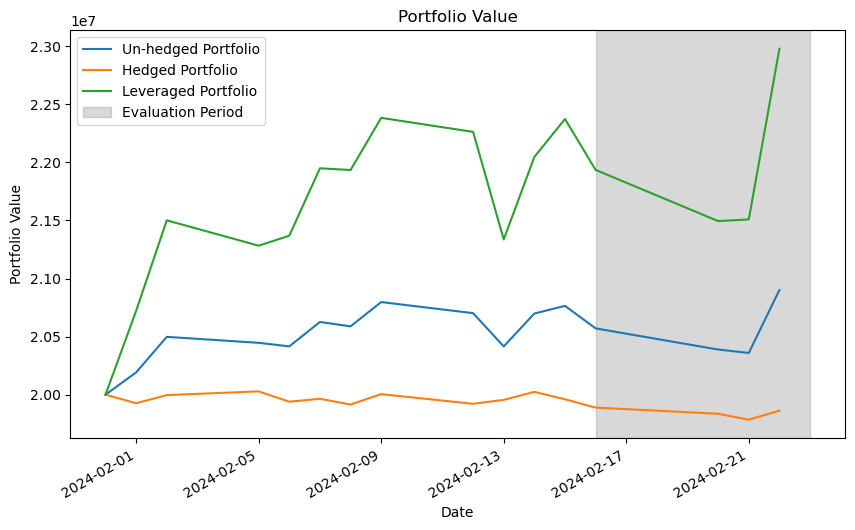

In [6]:
# Getting the futures price of the S&P 500 on January 31, 2024
futures_prices = yf.download('ESH24.CME', start="2024-01-31", end="2024-02-23")['Adj Close']

# Get futures gains over time
futures_gains_hedge = - (futures_prices - f) * h_star * S
futures_gains_hedge = futures_gains_hedge.to_frame().rename(columns={'Adj Close': 'Hedged Futures'})
futures_gains_leverage = - (futures_prices - f) * h_star_triple * S
futures_gains_leverage = futures_gains_leverage.to_frame().rename(columns={'Adj Close': 'Leveraged Futures'})

stock_prices = yf.download(sp500_stocks, start="2024-01-31", end="2024-02-23")['Adj Close']
stock_value = P / len(sp500_stocks)
shares = stock_value / stock_prices.iloc[0]

portfolios_value = (stock_prices * shares).sum(axis=1).to_frame().rename(columns={0: 'Un-hedged Portfolio'})  # Value of the portfolio form Jan 31 2024 to Feb 23 2024 
portfolios_value = portfolios_value.merge(futures_gains_hedge, left_index=True, right_index=True, how='inner').merge(futures_gains_leverage, left_index=True, right_index=True, how='inner')

portfolios_value['Hedged Portfolio'] = portfolios_value['Un-hedged Portfolio'] + portfolios_value['Hedged Futures']
portfolios_value['Leveraged Portfolio'] = portfolios_value['Un-hedged Portfolio'] + portfolios_value['Leveraged Futures']
portfolios_value = portfolios_value.drop(columns=['Hedged Futures', 'Leveraged Futures'])

eval_period = portfolios_value.loc['2024-02-16':'2024-02-23']
return_unhedged = (eval_period['Un-hedged Portfolio'].iloc[-1] - eval_period['Un-hedged Portfolio'].iloc[0]) / eval_period['Un-hedged Portfolio'].iloc[0] * 100
return_hedged = (eval_period['Hedged Portfolio'].iloc[-1] - eval_period['Hedged Portfolio'].iloc[0]) / eval_period['Hedged Portfolio'].iloc[0] * 100
return_leveraged = (eval_period['Leveraged Portfolio'].iloc[-1] - eval_period['Leveraged Portfolio'].iloc[0]) / eval_period['Leveraged Portfolio'].iloc[0] * 100
print("Portfolios Performance during the Evaluation Period (Feb 16 to Feb 23, 2024)")
print("Un-hedged Portfolio Return: {:.2f}%".format(return_unhedged))
print("Hedged Portfolio Return: {:.2f}%".format(return_hedged))
print("Leveraged Portfolio Return: {:.2f}%".format(return_leveraged))

fig, ax = plt.subplots()

portfolios_value['Un-hedged Portfolio'].plot(ax=ax, label='Un-hedged Portfolio')
portfolios_value['Hedged Portfolio'].plot(ax=ax, label='Hedged Portfolio')
portfolios_value['Leveraged Portfolio'].plot(ax=ax, label='Leveraged Portfolio')
ax.axvspan('2024-02-16', '2024-02-23', color='gray', alpha=0.3, label='Evaluation Period')
fig.set_size_inches(10, 6)
plt.title('Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


 
### Summary Report

#### 1. Portfolio Beta

The portfolio beta ($\beta_p$) was calculated using the average of reported betas for 30 equally weighted stocks selected from the S&P 500. The computed portfolio beta is:

$$ \beta_p = 1.113 $$

This beta reflects the portfolio's volatility in comparison to the market.

#### 2. S&P Futures Contracts Calculation

To hedge the portfolio, shorting S&P futures contracts was proposed to offset the portfolio beta. Additionally, a strategy to triple the portfolio's beta was considered, which involves taking a position in futures contracts to amplify the portfolio's market exposure.

##### a) Hedging the Portfolio Beta

The optimal number of futures contracts ($N^*$) to hedge the portfolio is:

$$ N^* = \frac{\beta_p \times P}{A} = \frac{1.113 \times \$20,000,000}{\$4870.50 \times 50} \approx 91.41 $$

This calculation indicates that approximately 91 contracts are required to be shorted to hedge the portfolio's beta.

##### b) Tripling the Portfolio Beta

To triple the portfolio beta, the required number of futures contracts is:

$$ N^* = \frac{-2 \times \beta_p \times P}{A} \approx -182.81 $$

A negative sign indicates a long position in futures contracts. About 183 contracts would be required to achieve the desired exposure.

#### 3. Evaluation of Portfolio Performance

The performance of the portfolio was evaluated over the period from February 16, 2024, to February 23, 2024. The returns for the unhedged, hedged, and leveraged portfolios are as follows:

- Un-hedged Portfolio Return: 1.60%
- Hedged Portfolio Return: -0.13%
- Leveraged Portfolio Return: 4.76%
